# Projekt - KM1

Challenge 3 - blue and yellow circles

Question 1: Explain the Kandinsky Pattern in an algorithmic way, i.e. train a network which classifies Kandinsky Figures according to ground truth of challenge 3.

## Pobranie danych

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py

In [ ]:
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns

Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./

In [ ]:
! mv ./challenge-nr-3 ./dataset

In [ ]:
! rm -R ./dat-kandinsky-patterns

In [ ]:
# na razie, do modelowania wstępnego

! rm -R ./dataset/counterfactual/

## Tworzenie datasetu

In [ ]:
import torch
import torchvision


if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

In [ ]:
DEVICE

'cuda:0'

In [ ]:
transforms = torchvision.transforms.Compose([
    # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
    # na GPU (oryginały mają 600x600)
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./dataset', transform=transforms)

In [ ]:
n = len(dataset)
n

2000

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [1600, 400])

# aby zachować na przyszłość ten sam podział
torch.save(train_set, '/content/drive/MyDrive/projekt-WB/train_set')
torch.save(test_set, '/content/drive/MyDrive/projekt-WB/test_set')

In [ ]:
# train_set = torch.load('/content/drive/MyDrive/projekt-WB/train_set')
# test_set = torch.load('/content/drive/MyDrive/projekt-WB/test_set')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

## Wstępne modelowanie

Część kodu zaczerpnieta z: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from resnet18 import ResNet18

In [ ]:
model = ResNet18()
model.linear = nn.Linear(41472, 2)
model = model.to(DEVICE)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 3

In [ ]:
from train_function import train

In [ ]:
train_acc, test_acc = train(model, criterion, optimizer, 0, epochs, train_loader, test_loader, DEVICE)

Epoch: 0, train accuracy: 0.985625, test accuracy: 1.0
Epoch: 1, train accuracy: 0.974375, test accuracy: 1.0
Epoch: 2, train accuracy: 1.0, test accuracy: 1.0


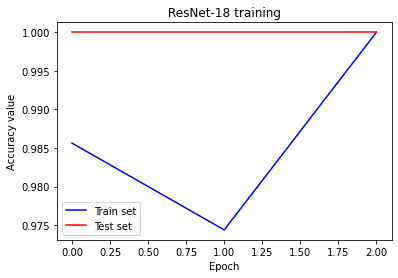

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/model_1.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/projekt-WB/train_acc_hist_1', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/projekt-WB/test_acc_hist_1', 'wb') as f:
    pickle.dump(test_acc, f)

## Macierz konfuzji

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

model.eval()

y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 576x576 with 0 Axes>

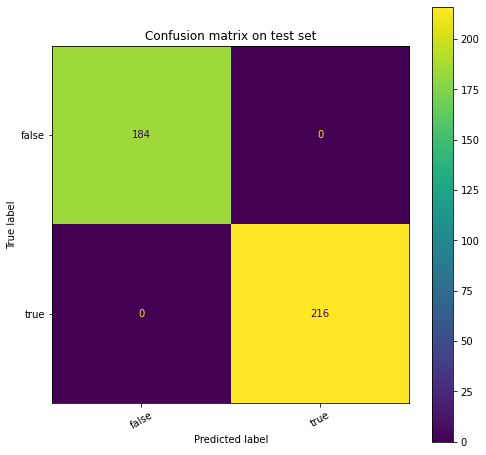

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.xticks(rotation=30)
plt.show()

Sieć bardzo dobrze wytrenowała się na tych danych

# Dodam teraz **counterfactual**

## Wczytanie danych

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py

In [ ]:
! rm -R ./dataset
! rm -R ./dat-kandinsky-patterns

rm: cannot remove './dat-kandinsky-patterns': No such file or directory


In [ ]:
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns

Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 36.96 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./
! mv ./challenge-nr-3 ./dataset

In [ ]:
! rm -R ./dat-kandinsky-patterns

In [ ]:
import torch
import torchvision

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

In [ ]:
transforms = torchvision.transforms.Compose([
    # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
    # na GPU (oryginały mają 600x600)
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./dataset', transform=transforms)

In [ ]:
n = len(dataset)
n

3000

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [2400, 600])

# aby zachować na przyszłość ten sam podział
torch.save(train_set, '/content/drive/MyDrive/projekt-WB/train_set_2')
torch.save(test_set, '/content/drive/MyDrive/projekt-WB/test_set_2')

In [ ]:
# train_set = torch.load('/content/drive/MyDrive/projekt-WB/train_set_2')
# test_set = torch.load('/content/drive/MyDrive/projekt-WB/test_set_2')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

## Modelowanie

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from resnet18 import ResNet18

In [ ]:
model = ResNet18(num_classes = 3)
model.linear = nn.Linear(41472, 3)
model = model.to(DEVICE)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 3

In [ ]:
from train_function import train

In [ ]:
train_acc, test_acc = train(model, criterion, optimizer, 0, epochs, train_loader, test_loader, DEVICE)

Epoch: 0, train accuracy: 0.6604166666666667, test accuracy: 0.6533333333333333
Epoch: 1, train accuracy: 0.71625, test accuracy: 0.69
Epoch: 2, train accuracy: 0.7504166666666666, test accuracy: 0.7016666666666667


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/model_2.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/projekt-WB/train_acc_hist_2', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/projekt-WB/test_acc_hist_2', 'wb') as f:
    pickle.dump(test_acc, f)

## Macierz konfuzji

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

model.eval()

y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 576x576 with 0 Axes>

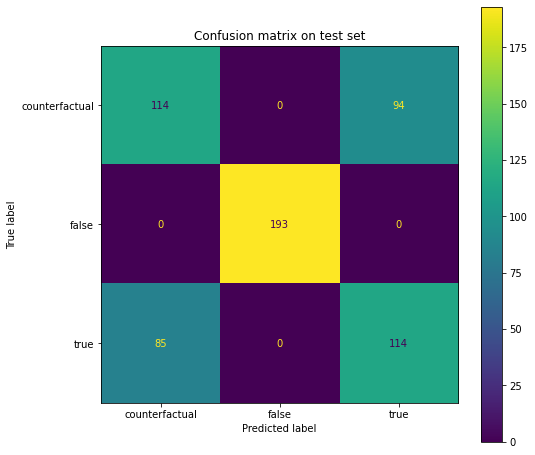

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.show()

### Dalsze trenowanie

In [ ]:
%%capture

model.train()

In [ ]:
epochs = 5

train_acc, test_acc = train(model, criterion, optimizer, 3, epochs, train_loader, test_loader, DEVICE, train_acc, test_acc)

Epoch: 3, train accuracy: 0.74125, test accuracy: 0.655
Epoch: 4, train accuracy: 0.7141666666666666, test accuracy: 0.6516666666666666
Epoch: 5, train accuracy: 0.7366666666666667, test accuracy: 0.6916666666666667
Epoch: 6, train accuracy: 0.7504166666666666, test accuracy: 0.6733333333333333
Epoch: 7, train accuracy: 0.7654166666666666, test accuracy: 0.73


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/model_2_1.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/projekt-WB/train_acc_hist_2_1', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/projekt-WB/test_acc_hist_2_1', 'wb') as f:
    pickle.dump(test_acc, f)

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

model.eval()

y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 576x576 with 0 Axes>

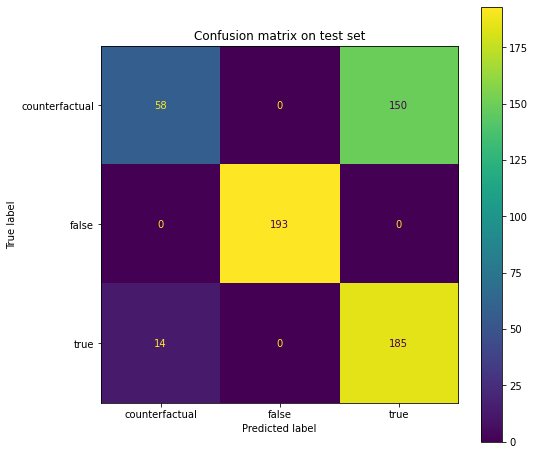

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.show()

In [ ]:
%%capture

model.train()

In [ ]:
epochs = 10

train_acc, test_acc = train(model, criterion, optimizer, 7, epochs, train_loader, test_loader, DEVICE, train_acc, test_acc)

Epoch: 7, train accuracy: 0.7841666666666667, test accuracy: 0.7066666666666667
Epoch: 8, train accuracy: 0.7954166666666667, test accuracy: 0.68
Epoch: 9, train accuracy: 0.75625, test accuracy: 0.7033333333333334
Epoch: 10, train accuracy: 0.7695833333333333, test accuracy: 0.6916666666666667
Epoch: 11, train accuracy: 0.8004166666666667, test accuracy: 0.7066666666666667
Epoch: 12, train accuracy: 0.7966666666666666, test accuracy: 0.7116666666666667
Epoch: 13, train accuracy: 0.80625, test accuracy: 0.7
Epoch: 14, train accuracy: 0.8254166666666667, test accuracy: 0.715
Epoch: 15, train accuracy: 0.8333333333333334, test accuracy: 0.705
Epoch: 16, train accuracy: 0.8504166666666667, test accuracy: 0.7183333333333334


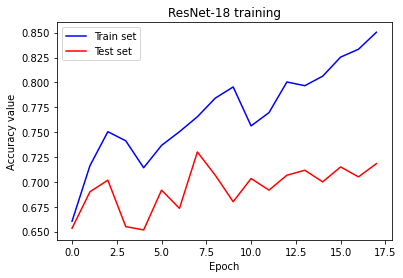

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/model_2_2.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/projekt-WB/train_acc_hist_2_2', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/projekt-WB/test_acc_hist_2_2', 'wb') as f:
    pickle.dump(test_acc, f)

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

model.eval()

y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 576x576 with 0 Axes>

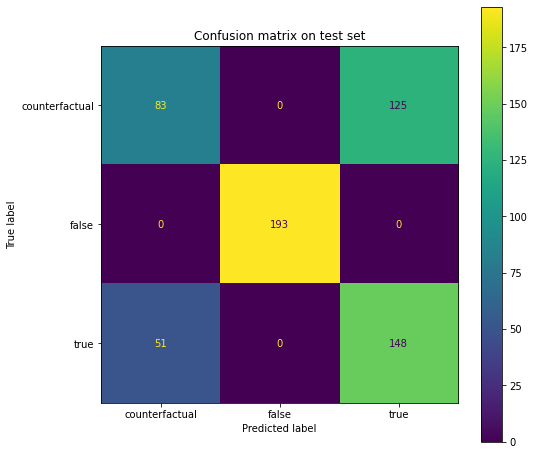

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.show()

Sieć się przetreowała oraz, jak widać powyżej, niezbyt nauczyła się rozróżniać klasę true od counterfactual

# Usunę teraz **false** i zostawię tylko **true** i **counterfalse**

## Wczytanie danych

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py

In [ ]:
! rm -R ./dataset
! rm -R ./dat-kandinsky-patterns
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./
! mv ./challenge-nr-3 ./dataset
! rm -R ./dat-kandinsky-patterns
! rm -R ./dataset/false/

rm: cannot remove './dat-kandinsky-patterns': No such file or directory
Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 30.96 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
import torch
import torchvision

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

In [ ]:
transforms = torchvision.transforms.Compose([
    # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
    # na GPU (oryginały mają 600x600)
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./dataset', transform=transforms)

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [1600, 400])

# aby zachować na przyszłość ten sam podział
torch.save(train_set, '/content/drive/MyDrive/projekt-WB/train_set_3')
torch.save(test_set, '/content/drive/MyDrive/projekt-WB/test_set_3')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

## Modelowanie

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from resnet18 import ResNet18

In [ ]:
model = ResNet18(num_classes = 2)
model.linear = nn.Linear(41472, 2)
model = model.to(DEVICE)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 10

In [ ]:
from train_function import train

In [ ]:
train_acc, test_acc = train(model, criterion, optimizer, 0, epochs, train_loader, test_loader, DEVICE)

Epoch: 0, train accuracy: 0.525625, test accuracy: 0.5425
Epoch: 1, train accuracy: 0.555, test accuracy: 0.615
Epoch: 2, train accuracy: 0.580625, test accuracy: 0.5725
Epoch: 3, train accuracy: 0.595625, test accuracy: 0.5525
Epoch: 4, train accuracy: 0.641875, test accuracy: 0.595
Epoch: 5, train accuracy: 0.643125, test accuracy: 0.5475
Epoch: 6, train accuracy: 0.67625, test accuracy: 0.5575
Epoch: 7, train accuracy: 0.699375, test accuracy: 0.56
Epoch: 8, train accuracy: 0.705625, test accuracy: 0.645
Epoch: 9, train accuracy: 0.778125, test accuracy: 0.6675


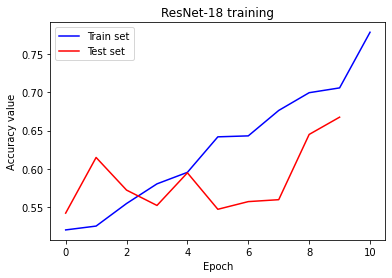

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/model_3.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/projekt-WB/train_acc_hist_3', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/projekt-WB/test_acc_hist_3', 'wb') as f:
    pickle.dump(test_acc, f)

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

model.eval()

y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 576x576 with 0 Axes>

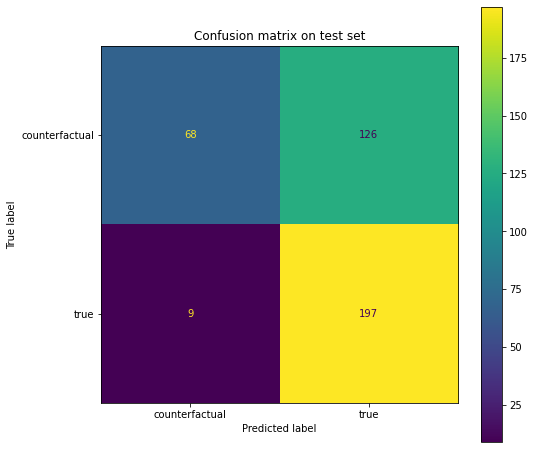

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.show()

# Połączę teraz **false** z **counterfalse**, a drugą klasą będzie **true**

## Wczytanie danych

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py

In [ ]:
! rm -R ./dataset
! rm -R ./dat-kandinsky-patterns
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./
! mv ./challenge-nr-3 ./dataset

rm: cannot remove './dat-kandinsky-patterns': No such file or directory
Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
import os

folder = './dataset/counterfactual/'

for count, filename in enumerate(os.listdir(folder)):
    dst = filename + "_counterfactual.png"
    src =f"{folder}/{filename}"
    dst =f"{folder}/{dst}"
    os.rename(src, dst)

In [ ]:
! cp -r ./dataset/counterfactual/. ./dataset/false/
! rm -R ./dat-kandinsky-patterns
! rm -R ./dataset/counterfactual/

In [ ]:
import torch
import torchvision

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

In [ ]:
transforms = torchvision.transforms.Compose([
    # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
    # na GPU (oryginały mają 600x600)
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./dataset', transform=transforms)

In [ ]:
len(dataset)

3000

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [2400, 600])

# aby zachować na przyszłość ten sam podział
torch.save(train_set, '/content/drive/MyDrive/projekt-WB/train_set_4')
torch.save(test_set, '/content/drive/MyDrive/projekt-WB/test_set_4')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

## Modelowanie

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from resnet18 import ResNet18

In [ ]:
model = ResNet18(num_classes = 2)
model.linear = nn.Linear(41472, 2)
model = model.to(DEVICE)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 10

In [ ]:
from train_function import train

In [ ]:
train_acc, test_acc = train(model, criterion, optimizer, 0, epochs, train_loader, test_loader, DEVICE)

Epoch: 0, train accuracy: 0.6404166666666666, test accuracy: 0.695
Epoch: 1, train accuracy: 0.6954166666666667, test accuracy: 0.7066666666666667
Epoch: 2, train accuracy: 0.7554166666666666, test accuracy: 0.685
Epoch: 3, train accuracy: 0.7604166666666666, test accuracy: 0.7983333333333333
Epoch: 4, train accuracy: 0.81625, test accuracy: 0.8183333333333334
Epoch: 5, train accuracy: 0.8075, test accuracy: 0.7933333333333333
Epoch: 6, train accuracy: 0.8383333333333334, test accuracy: 0.8233333333333334
Epoch: 7, train accuracy: 0.8591666666666666, test accuracy: 0.7633333333333333
Epoch: 8, train accuracy: 0.8620833333333333, test accuracy: 0.83
Epoch: 9, train accuracy: 0.8816666666666667, test accuracy: 0.815


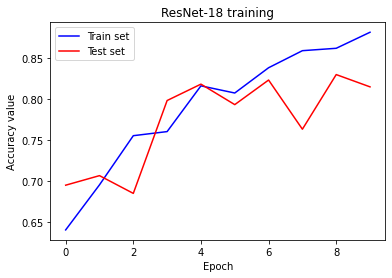

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/model_4.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/projekt-WB/train_acc_hist_4', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/projekt-WB/test_acc_hist_4', 'wb') as f:
    pickle.dump(test_acc, f)

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

model.eval()

y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 576x576 with 0 Axes>

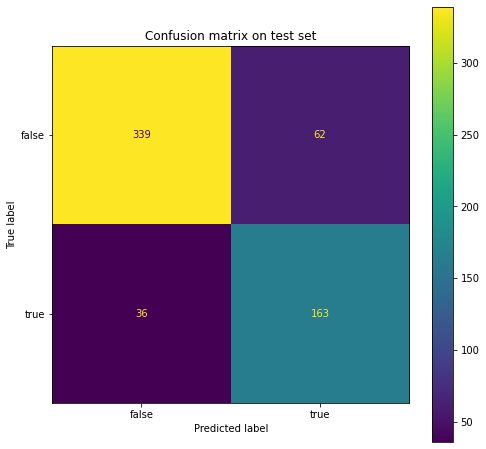

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.show()

## Próba pierwszych wyjaśnień

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py

In [ ]:
! rm -R ./dataset
! rm -R ./dat-kandinsky-patterns
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./
! mv ./challenge-nr-3 ./dataset

rm: cannot remove './dat-kandinsky-patterns': No such file or directory
Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 24.71 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
import os

folder = './dataset/counterfactual/'

for count, filename in enumerate(os.listdir(folder)):
    dst = filename + "_counterfactual.png"
    src =f"{folder}/{filename}"
    dst =f"{folder}/{dst}"
    os.rename(src, dst)

In [ ]:
! cp -r ./dataset/counterfactual/. ./dataset/false/
! rm -R ./dat-kandinsky-patterns
! rm -R ./dataset/counterfactual/

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from resnet18 import ResNet18


transforms = torchvision.transforms.Compose([
    # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
    # na GPU (oryginały mają 600x600)
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./dataset', transform=transforms)

#zaladowanie test
test_set = torch.load('/content/drive/MyDrive/projekt-WB/test_set_4')

model = ResNet18()
model.linear = nn.Linear(41472, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/projekt-WB/model_4.model'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
! pip install captum

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

In [ ]:
idx = 0

i = 0
img = None
for batch in single_test_loader:  
      if i == idx:
          img = batch[0][0]
          label = batch[1]
          break
      i = i + 1

_, predicted = model(img.unsqueeze(0)).max(1)
predicted = predicted.item()

In [ ]:
print(f'Classification explanation, predicted class: {dataset.classes[predicted]}, true class: {dataset.classes[label.item()]}')

Classification explanation, predicted class: true, true class: true


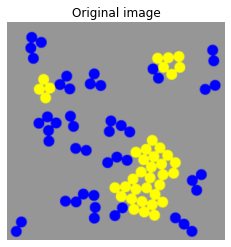

In [ ]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.title('Original image')
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
from captum.attr import Lime, IntegratedGradients, KernelShap
from skimage import segmentation

In [ ]:
from explain import lime_explain

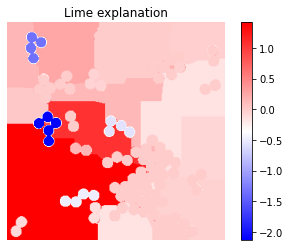

In [ ]:
lime_explain(model, img, label.item())
plt.title("Lime explanation")
plt.show()

In [ ]:
from explain import SHAP_explain

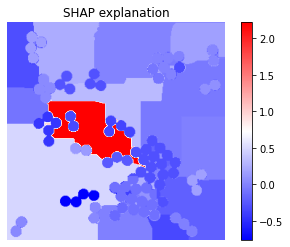

In [ ]:
import matplotlib.pyplot as plt

SHAP_explain(model, img, label)
plt.title("SHAP explanation")
plt.show()

# Przeczytane artykuły:

## Embracing Causality in Formal Reasoning

https://www.aaai.org/Papers/AAAI/1987/AAAI87-066.pdf

Patryk Tomaszewski

W swoim artykule "Embracing Causality in Formal Reasoning", Judea Pearl podkreśla różnicę pomiędzy wnioskowaniem na bazie oczekiwań (jeżeli widzimy ogień, możemy spodziewać się że pojawi się też dym), a wnioskowaniem na bazie przyczyn (jeżeli widzimy dym, możemy się spodziewać że jego przyczyną jest ogień). Następnie przedstawia wyjaśnienie, czemu system logiczny nierozróżniający tych dwóch rodzajów wnioskowania nigdy nie będzie w pełni adekwatny, oraz proponuje rozwiązanie, zwane "C-E System", które jest w stanie wykorzystać te rozróżnienie. Znajomość zależności prezentowanych przez artykuł może okazać się użyteczna podczas próby wnioskowania matematycznego, na przykład wyjaśnienia odpowiedzi modelu uczenia maszynowego. W artykule autor używa prostych i intuicyjnych przykładów, co znacząco ułatwia zrozumienie rozważanego problemu, jednak nawet pomimo tego zabiegu artykuł należy przeczytać wielokrotnie aby go w pełni zrozumieć.

## Learning like a Child: Fast Novel Visual Concept Learning from Sentence Descriptions of Images 

https://arxiv.org/pdf/1504.06692.pdf

Adrian Stańdo

Artykuł "Learning like a Child: Fast Novel Visual Concept Learning from Sentence Descriptions of Images" dotyczy tzw. concept learning. Pojęcie to jest dobrze opisane przez Toma Michella jako "problem przeszukiwania predefiniowanej przestrzeni potencjalnych hipotez pod kątem hipotezy najlepiej pasującej do przykładów uczących". Dokładniej, w artykule została pokazana technika uczenia sieci na podstawie opisu obrazka, a predykcja sieci to również opis. W ten sposób, model musi odnaleźć nie tylko elementy na rysunku, ale także słowa najlepiej go opisujące. W artykule opisano technikę dotrenowywania sieci, wzorując się na sposobie, w jaki dzieci uczą się znaczenia nowych słów. W efekcie, sieć osiągała nawet lepsze wyniki niż sieć, która została wytrenowana od nowa. Jednakże, takie wyniki były osiągane tylko dla nowych zdjęć, które w jakiś sposób były podobne do zdjęć oryginalnych, np. zawierające psa i kota. Kiedy dodawano zdjęcia przedstawiające quidditch, t-rexa lub shamisen (elementy nie pojawiały się w żaden sposób w oryginalnym zbiorze uczącym), sieć osiągała gorsze wyniki.

Autorzy artykułu "Kandinsky Patterns" jako jedno z wyzwań stawiają stworzenie słownego opisu wzorca. Ponadto, cytują oni opisany przeze mne artykuł w kotekście przykładu, w jaki sposób można opisać zdjęcia.


## Measuring abstract reasoning in neural networks

http://proceedings.mlr.press/v80/santoro18a/santoro18a.pdf

Krzysztof Wodnicki

Wybrany przezemnie arykuł zajmuje się zagadnieniem oceny zdolności sieci neuronowych do rozpoznawania abstrakcyjnych wzroców. Autorzy zaproponowali wykorzystanie popularnych wizualnych testów na inteligencję do porównania różnych modeli, przygotowali odpowiedni zbiór danych i wyszkolili na nim sieci o różnych architekturach. Oprócz popularnych architektur takich jak podstawowy CNN czy ResNet, zaproponowali też własne architektury - WReN (Wild Relation Network) i Wild-ResNet. Do rozwiązania zaproponowanego problemu najskuteczniejszy okazał się model WReN, prowdopodobnie ponieważ jest on stworzony tak aby skutecznie rozpoznawać relacje między obiektami. W trakcie swoich badań autorzy tworzyli pewne zasadnicze różnice pomiędzy zbiorami testowym i treningowym, co pozwoliło im sprawdzić które z tych różnic model jest w stanie obejść generalizując rozpoznaną regułę.